In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [38]:
df = pd.read_pickle("./data/train.pkl")

In [47]:
w = pd.read_pickle("./data/weather_train.pkl")

In [39]:
meta = pd.read_pickle("./data/building_metadata.pkl")

In [40]:
df = df.merge(meta, on='building_id', how='left')

In [41]:
df['month'] = df.timestamp.dt.month

In [43]:
stat = df.groupby(['site_id', 'meter', 'month'])['meter_reading'].median().reset_index().rename(columns={'meter_reading': 'tmp'})

In [44]:
stat

,site_id,meter,month,tmp
0,0,0,1,0.000000
1,0,0,2,0.000000
2,0,0,3,0.000000
3,0,0,4,0.000000
4,0,0,5,0.000000
...,...,...,...,...
462,15,3,8,281.845520
463,15,3,9,737.846008
464,15,3,10,1193.959961
465,15,3,11,871.461975


In [27]:
stat= stat

In [29]:
df = pd.merge(df, stat, on=['site_id', 'meter', 'month'], how='left')

In [32]:
df.tmp.isnull().sum()

0

In [49]:
w['month'] = w.timestamp.dt.month

In [54]:
w_stat = w.groupby(['site_id', 'month'])['air_temperature'].median().reset_index()

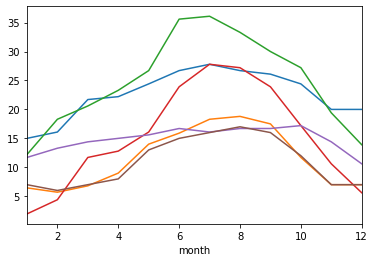

In [69]:
w_stat[w_stat.site_id == 0].set_index('month').air_temperature.plot()
w_stat[w_stat.site_id == 1].set_index('month').air_temperature.plot()
w_stat[w_stat.site_id == 2].set_index('month').air_temperature.plot()
w_stat[w_stat.site_id == 3].set_index('month').air_temperature.plot()
w_stat[w_stat.site_id == 4].set_index('month').air_temperature.plot()
w_stat[w_stat.site_id == 5].set_index('month').air_temperature.plot()

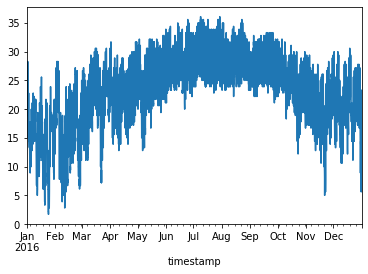

In [67]:
w[w.site_id == 0].set_index('timestamp').air_temperature.plot()

In [62]:
stat

,site_id,meter,month,tmp
0,0,0,1,0.000000
1,0,0,2,0.000000
2,0,0,3,0.000000
3,0,0,4,0.000000
4,0,0,5,0.000000
...,...,...,...,...
462,15,3,8,281.845520
463,15,3,9,737.846008
464,15,3,10,1193.959961
465,15,3,11,871.461975


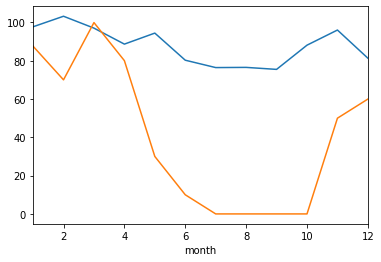

In [65]:
stat[(stat.meter==0) & (stat.site_id==1)].set_index("month").tmp.plot()
stat[(stat.meter==3) & (stat.site_id==1)].set_index("month").tmp.plot()

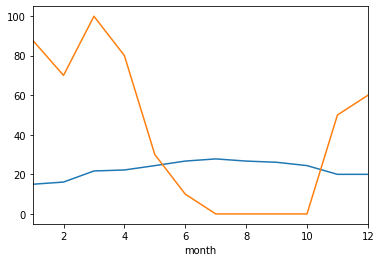

In [71]:
w_stat[w_stat.site_id == 0].set_index('month').air_temperature.plot()
stat[(stat.meter==3) & (stat.site_id==1)].set_index("month").tmp.plot()

In [45]:
stat

,site_id,meter,month,tmp
0,0,0,1,0.000000
1,0,0,2,0.000000
2,0,0,3,0.000000
3,0,0,4,0.000000
4,0,0,5,0.000000
...,...,...,...,...
462,15,3,8,281.845520
463,15,3,9,737.846008
464,15,3,10,1193.959961
465,15,3,11,871.461975


In [33]:
df.columns

Index(['building_id', 'meter', 'timestamp', 'meter_reading', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count', 'month',
       'tmp'],
      dtype='object')

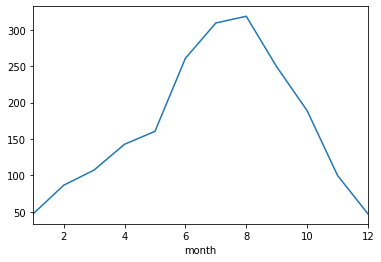

In [21]:
stat[(stat.meter==1) & (stat.site_id==2)].set_index("month").meter_reading.plot()

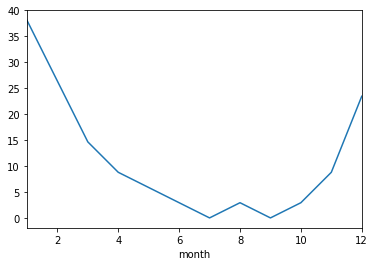

In [22]:
stat[(stat.meter==3) & (stat.site_id==2)].set_index("month").meter_reading.plot()

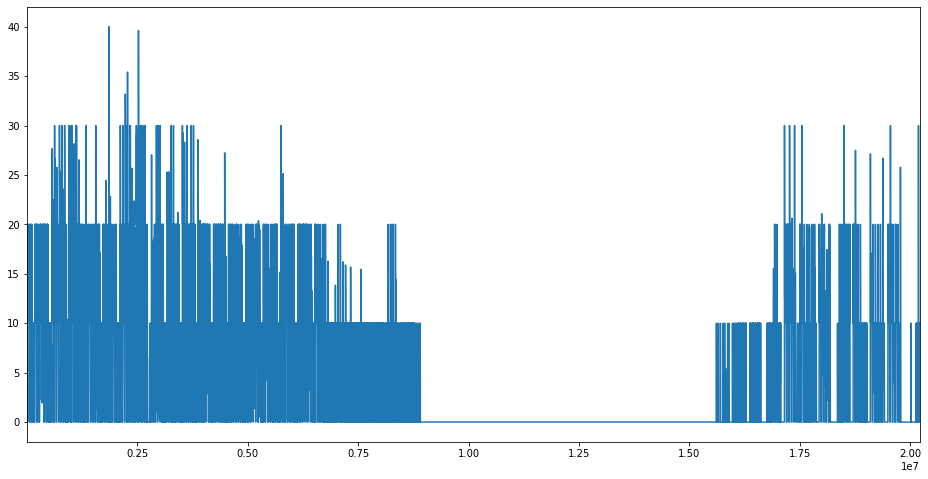

In [19]:
df[(df.building_id == 106) & (df.meter == 3)].meter_reading.plot(figsize=(16, 8))

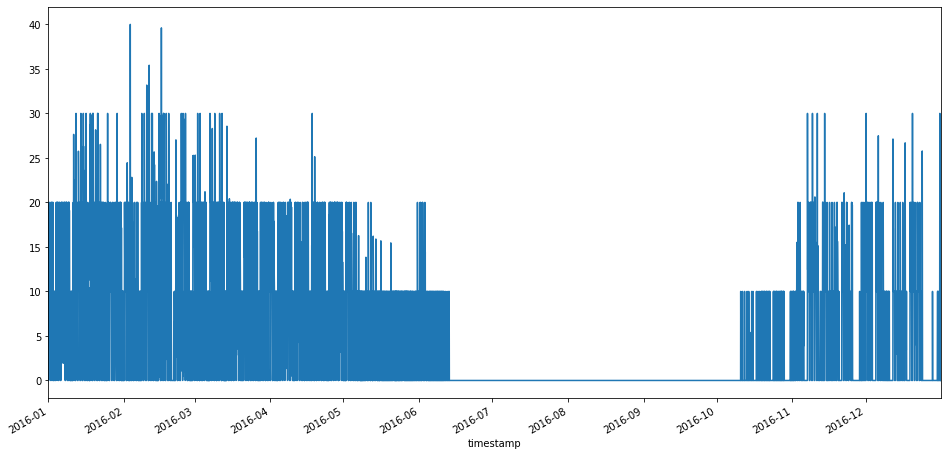

In [23]:
df[(df.building_id == 106) & (df.meter == 3)].set_index('timestamp').meter_reading.plot(figsize=(16, 8))

In [33]:
np.convolve([1,3,3,4,5,6], [0.25, 0.5, 0.25], mode='same')

array([1.25, 2.5 , 3.25, 4.  , 5.  , 4.25])

In [40]:
np.dot(np.array(0.25, 0.5, 0.25).reshape(1, -1), np.array([0, 1, 3]).reshape(-1,1))

ValueError: only 2 non-keyword arguments accepted

In [45]:
np.dot(np.array([1,3,3]), np.array([0.25, 0.5, 0.25]))

2.5

In [49]:
np.pad([1,2,3], (1,1), mode='edge')

array([1, 1, 2, 3, 3])

In [54]:
def smooth(x, weight):
    pad_width = int((len(weight) - 1) / 2)
    x_pad = np.pad(x, pad_width, mode='edge')
    return np.convolve(x_pad, weight, mode='valid')

In [55]:

x = [1,3,3,4,5,6]
box = [0.25, 0.5, 0.25]

In [56]:
smooth(x, box)

array([1.5 , 2.5 , 3.25, 4.  , 5.  , 5.75])

In [57]:
x = df[(df.building_id == 106) & (df.meter == 3)].set_index('timestamp').meter_reading.values

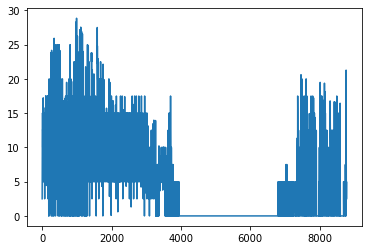

In [60]:
plt.plot(smooth(x, box))

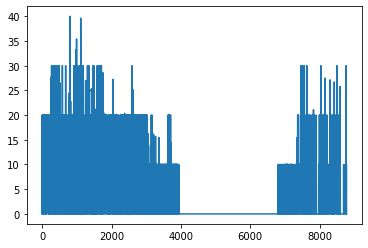

In [61]:
plt.plot(df[(df.building_id == 106) & (df.meter == 3)].set_index('timestamp').meter_reading.values)